In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot
from EDA_class import EDA

8


### Introduction

In this EDA, I will deal with only the Accepted dataset. As both datasets are very large, this should suffice to extract the desired insights. I will also carry out this EDA with the goal of exploring risk. To this end, we reduce the dataset to only rows where the loan status is either Fully Paid or Charged Off.

In [2]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv')
df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

/var/folders/wg/rc950kx52952n0613q25df340000gn/T/ipykernel_35680/2953743807.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('accepted_2007_to_2018Q4.csv')


In [3]:
EDA = EDA(df)

#### Question 1: Are interest rates reflective of risk?

Interest rate does tend to be higher for loans that default. We can see this by comparing the mean interest rate for charged off loans versus fully paid loans.

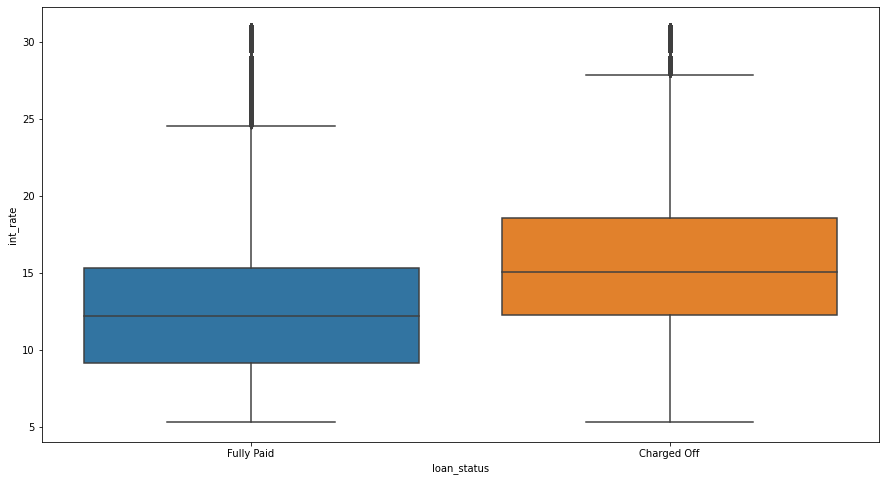

In [4]:
EDA.boxplot('loan_status', 'int_rate')

However, a question we can ask is are defaults more likely to occur because the interest rate is too high for a person to be able to repay the loan, or are interest rates indicative of the lender's risk assessment before deciding to go through with the loan.

We can explore this by using another metric we know to be reflective of the lender's risk asssessment.

Intuituively, the grade and sub_grade columns are reflective of how risky lenders considered a loan. We can confirm this by comparing the default rates for each of them.

[0.06040665277127909,
 0.1338515713918333,
 0.2243964934527334,
 0.30382228680338186,
 0.38478376935397757,
 0.4520244556740907,
 0.49934296977660975]

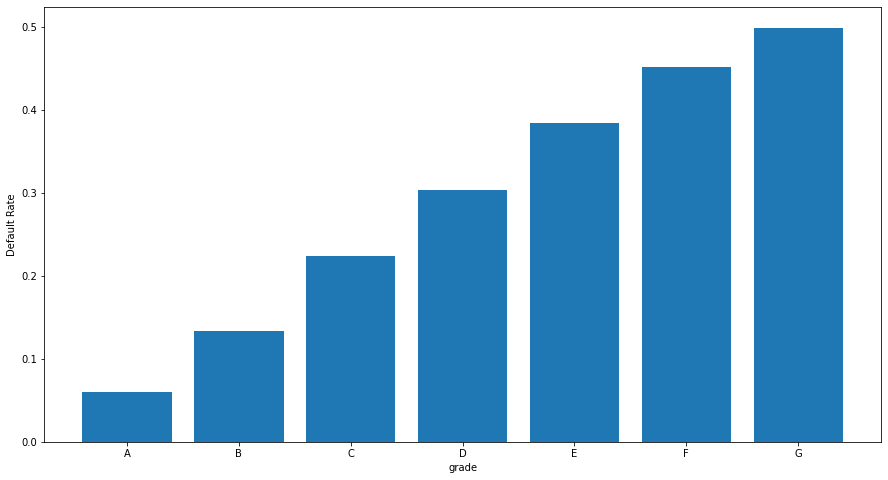

In [5]:
EDA.default_rate_barplot('grade')

Now, we can see how interest rate varies by loan grade. Under the assumption that interest rates are decided at the same time as the grade, this would indicate that the lender applies interest rate according to their evaluated risk.

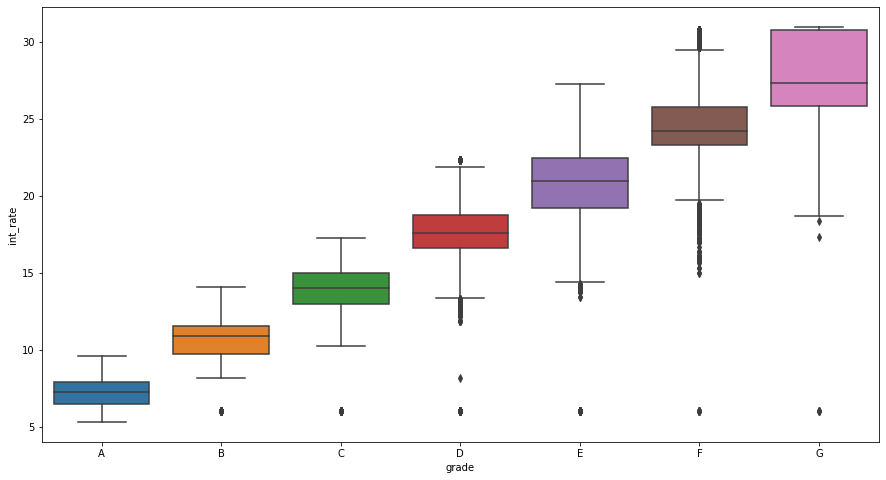

In [6]:
EDA.boxplot(x='grade', y='int_rate', sort=True)

This is as expected, and hence interest rate is reflective of risk.

#### Question 2: How does the default rate vary by purpose?

[0.14679465203976688,
 0.16927041882423063,
 0.21146938247208522,
 0.17177914110429449,
 0.17715761565185592,
 0.21880601130566663,
 0.1859983007646559,
 0.21775749003471775,
 0.23354430379746835,
 0.21040128410914927,
 0.23687031082529475,
 0.2970939283860924,
 0.19172642029784887,
 0.12162162162162163]

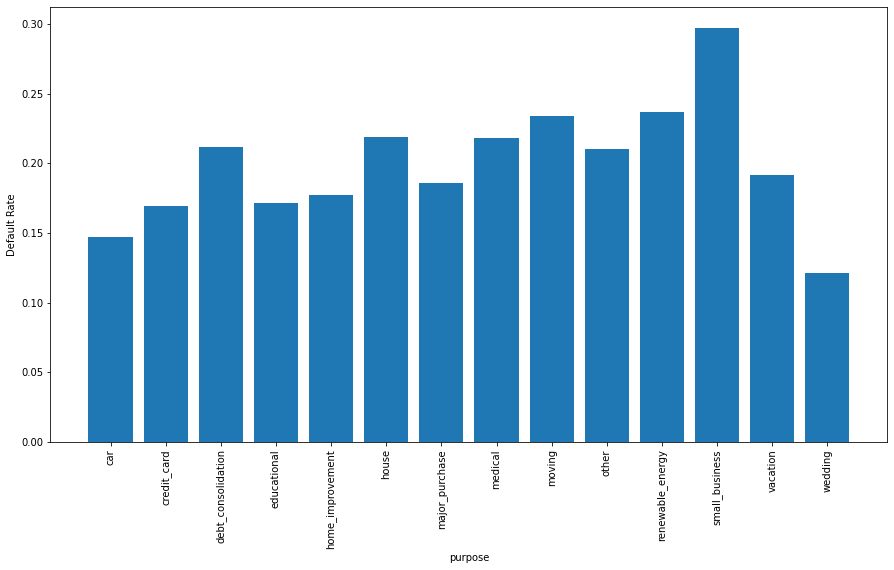

In [7]:
EDA.default_rate_barplot('purpose', rotate=True)

There is clearly significant variation. Loans taken for small businesses have the highest default rates at approximately 30%, while those for weddings and cars (smaller purchases that are arguably necessities) have the lowest.

Small businesses failing to repay these loans would suggest that they tend to fail at a high rate. Furthermore, given just the information available, lenders find it more difficult to predict if they fail or not indicating dependence on external factors (like the economy).

#### Question 3: How do loan amounts vary by purpose?

We ask this to verify the hypothesis that cars and weddings are indeed smaller purchases as well as explore if purposes like renewable energy (which has the second highest default rate) are small or large. The following plot also splits by if the loans were fully paid or charged off.



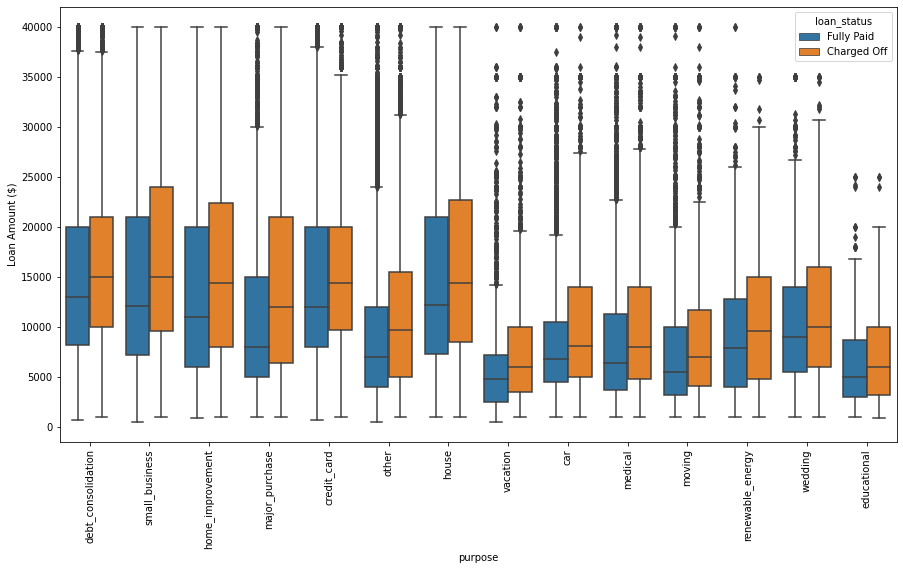

In [8]:
EDA.loan_amount_barplot('purpose')

We note that our assumption of what purchases are smaller were correct.

However, we also see that loan amount alone is not at all a good indicator of default likelihood. Vacations and renewable energy loans have relatively small average amounts but have much higher default rates in comparison. These might be due to things such as vacation loans being potentially predatory in nature.

#### Question 4: How do default rates, and in particular small business default rates, vary by state?

As noted earlier, there are potentially environmental factors not wholly reflected in the data that might be responsible for defaults. These could potentially be represented by which states loans are granted in (as they may have different economic circumstances).

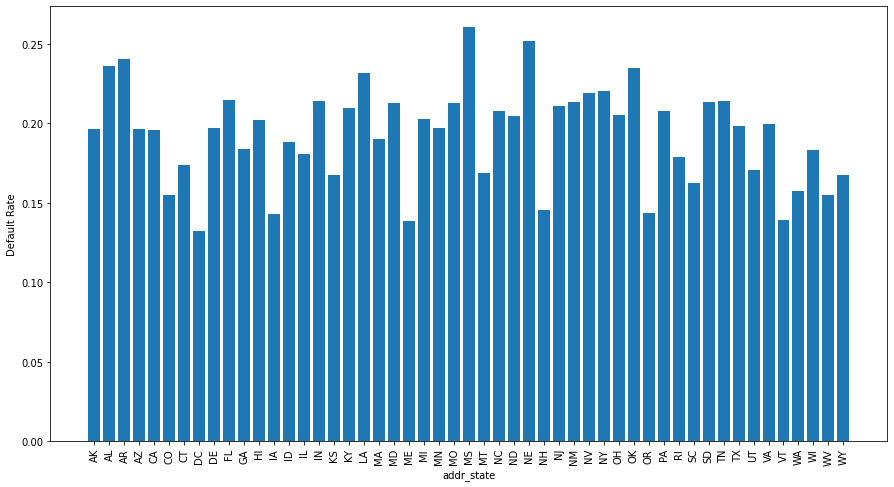

In [9]:
default_rates = EDA.default_rate_barplot('addr_state', rotate=True)

There is again significant variation.

DC has the lowest default rate of any state at around 13% while MS has nearly double that. Annual income might be a factor in this as DC has the highest median household income of any state while MS has the lowest (https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income).

We also look at the small business loan default rates.

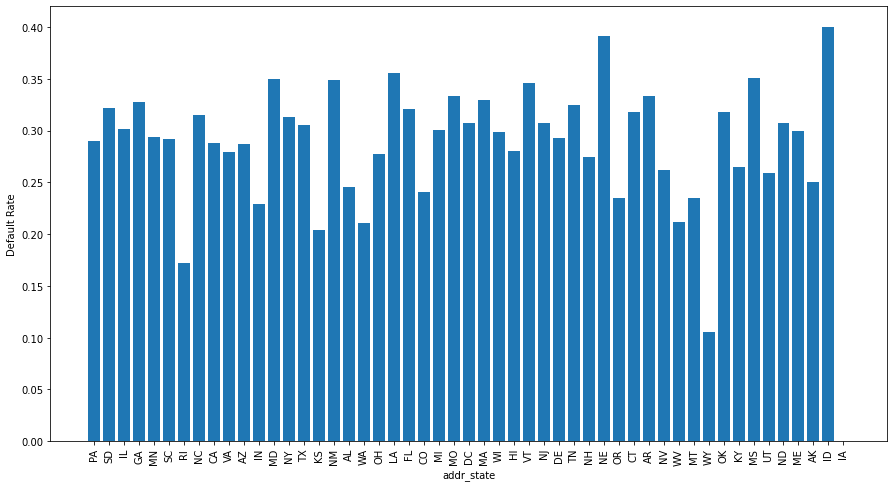

In [10]:
EDA.default_rate_by_purpose(purpose='small_business',split='addr_state')

The state clearly has a major influence. The lowest default rate is for WY at roughly 10%, while the highest is ID which is at 40% (4 times more!). This is also much greater variation than all-purpose data. Therefore it might be wise to incorporate more state information when evaluating small business loans.

#### Question 5: Does the annual income of each state affect their default rates?

We explore one such possible metric.

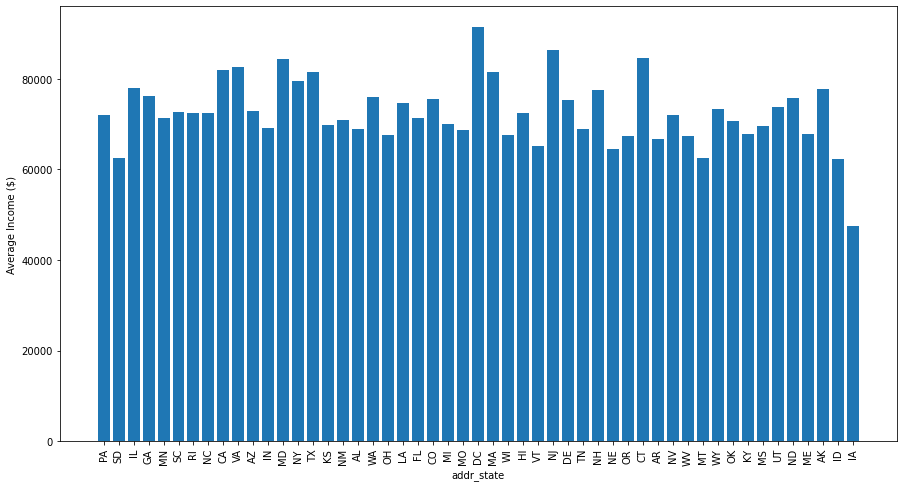

In [11]:
incomes = EDA.incomes_barplot(split='addr_state')

These values do roughly match income rankings found online.

We can now find the correlation between the average annual incomes and default rates by state.

In [12]:
print('Correlation: ', np.corrcoef(incomes, default_rates)[0][1])

Correlation:  0.11827886901931568


The correlation being negative is intuitive (lower income states have higher default rates). However, it is a fairly small value indicating more statewise data would be quite useful.

#### Question 6: How does average interest rate (as a measure of the environment) affect the likelihood of a loan being charged off?

We continue to examine factors relating to the economy and how they may affect loan default rates. Interest rate generally corresponds to the state of an economy (rates would be lower if the economy were worse to incentivise more spending).

We find the average interest rates by time period and compare that to default rates over the same time period. The years and months are extracted from issue_d to find the mean default and interest rates for each year.

Correlation:  0.21837591807014917


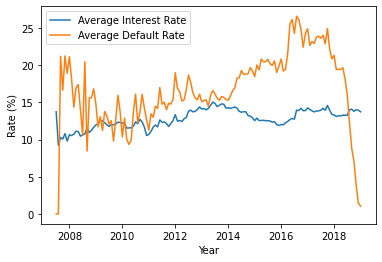

In [13]:
EDA.rates_by_year()

While the trend does have discrepancies (specifically at the end of the series), we can clearly observer some correlation and measure it as 0.218. This is not insignificant, and hence we can use interest rate (and other economic variables if available) as a predictor of default rates.

#### Question 7: Are verified loans likelier to be fully paid?

This seems intuitive as one would expect loans with unverified income to be riskier. We compute the default rates for each verification category.

[0.1467460025979724, 0.20954854749814397, 0.2385450929396466]

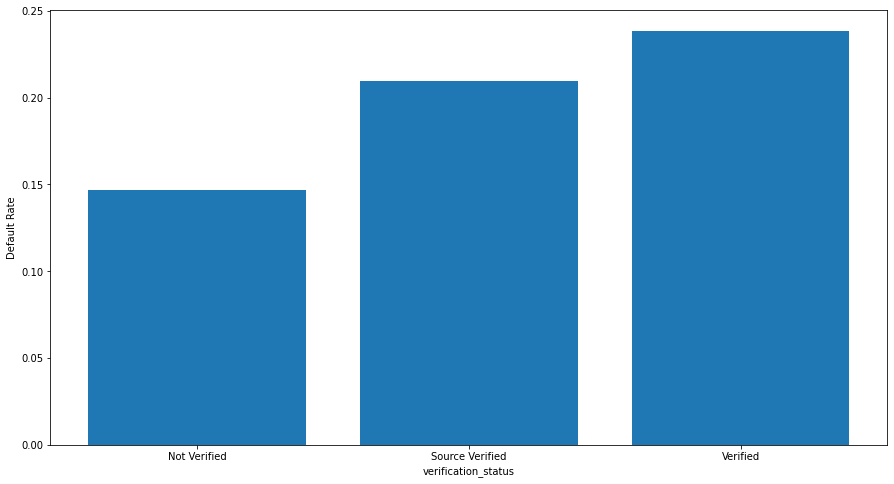

In [14]:
EDA.default_rate_barplot('verification_status')

Verified loans have higher default rates than unverified ones, which is the opposite of what was expected. We compare interest rates for each to confirm if the lenders saw unverified loans as riskier.

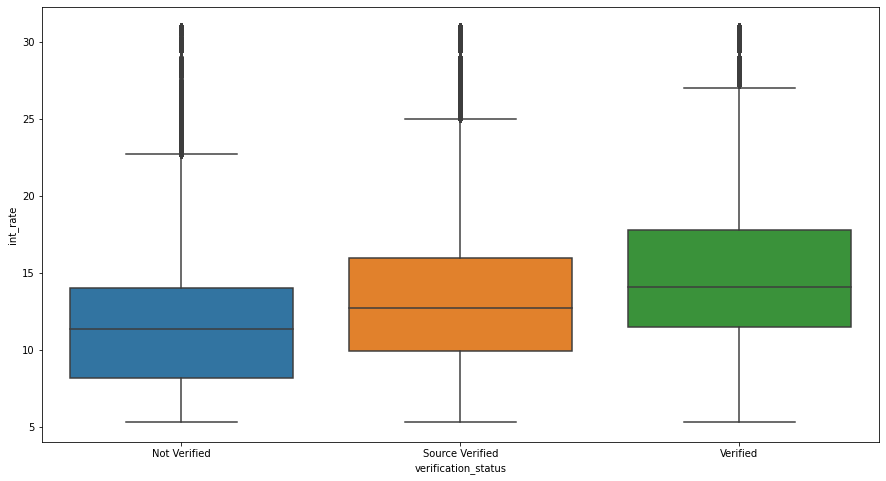

In [15]:
EDA.boxplot(x='verification_status', y='int_rate')

As this is the case, lenders must either use other metrics as indicators of default likelihood and perhaps verify only in cases where the loan is already deemed to be riskier.

#### Question 8: How are FICO scores and loan grades related?

We want to understand what metrics these may be. One such possible metric is the FICO score.

First, note that fico_range_high and fico_range_low have extremely high correlation and hence do not add much as separate variables at this cursory level.

In [16]:
EDA.correlation('fico_range_high', 'fico_range_low')

Correlation:  0.9999999320822981


Hence, we average them into a single FICO metric. 

As there are too many points to form an informative scatter plot, we can instead make boxplots for FICO scores for each grade which we already know to have positive correlation with default rates.

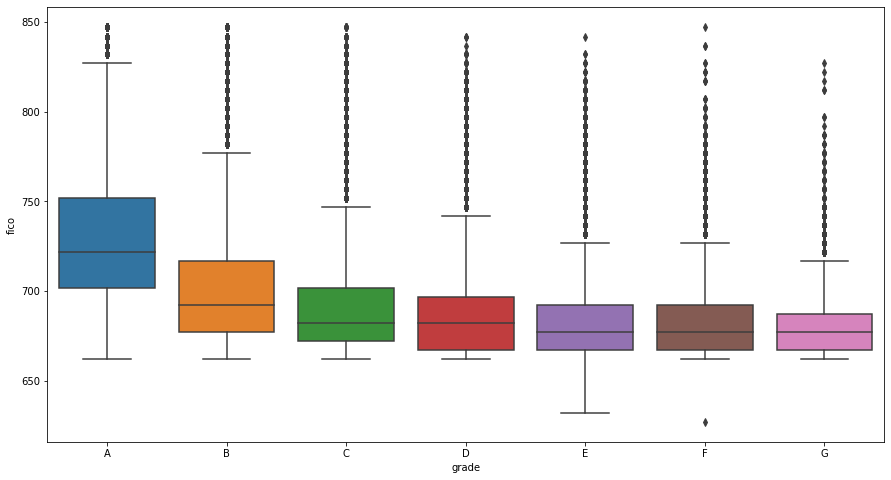

In [17]:
EDA.boxplot(x='grade', y='fico', sort=True)

There is clearly a negative correlation. We can also verify this by finding the correlation of fico scores with interest rates.

In [18]:
EDA.correlation('fico', 'int_rate')

Correlation:  -0.4053654961017694


As expected, we have a strong negative correlation.

#### Question 9: Is the number of inquiries an indicator of default likelihood?

We can also examine our hypothesis that verification only occurs when a potential loanee has already been identified as risky using the inq_last_6mths column, which holds the number of personal finance inquiries into the applicant in the last 6 months. These should be analogous to attempts to verify.

Being an ordinal variable, we can visualize the default rates on a bar plot.

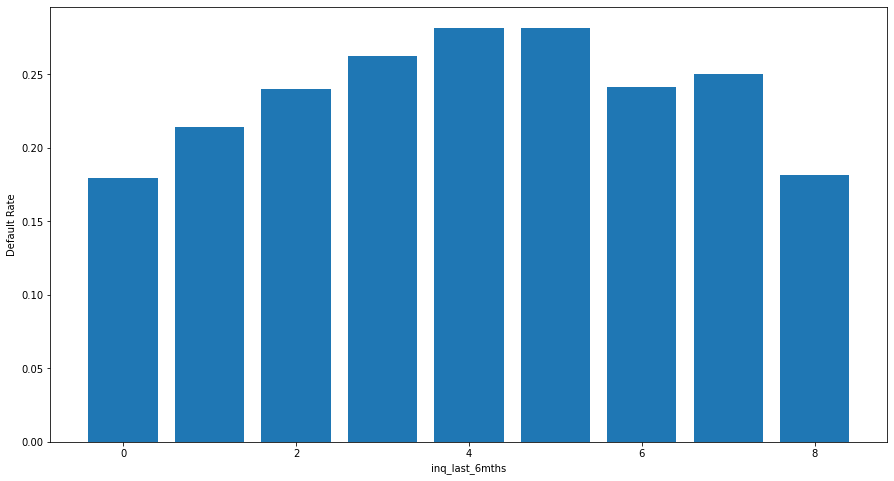

In [19]:
default_rates = EDA.default_rate_barplot('inq_last_6mths')

Aside from where the value is very high (likely outliers), we can see a positive trend. There seems to be a positive trend initially but a negative one as the values get very high. These may be outliers, which we can confirm with simple value counting.

In [20]:
df['inq_last_6mths'].value_counts()

0.0    770417
1.0    366681
2.0    136791
3.0     51659
4.0     13862
5.0      4888
6.0       941
7.0        48
8.0        22
Name: inq_last_6mths, dtype: int64

The last few values are clearly outliers. Let's drop 7 and 8 and compute the correlation.

In [21]:
inquiries = range(7)
print("Correlation: ", np.corrcoef(inquiries, default_rates[:7])[0][1])

Correlation:  0.7529195633305058


This is very significant correlation and hence we can confirm our hypothesis and use inq_last_6mths as a predictor of a loan being charged off.

...

#### Question 10: Does how long someone has had a credit line impact their chance of a successful loan?

Younger people tend to get the shorter hand of the stick when it comes to getting loans, and often times the loans they do get put them in debt for long durations of time.

While there is no age metric, we can perhaps estimate it by subtracting how long someone has had their earliest credit line for at the time of the issue date. We call this column cr_line_yrs.

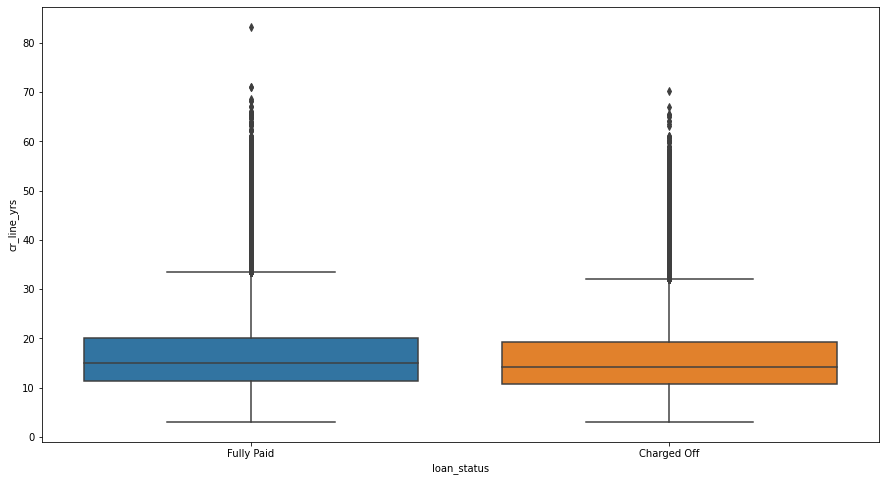

In [22]:
EDA.boxplot(x='loan_status', y='cr_line_yrs')

Surprisingly, there is not much difference although it is slightly in favour of our hypothesis that loanees with a shorter credit history will struggle to pay back their debt. We can also investigate this by purpose.

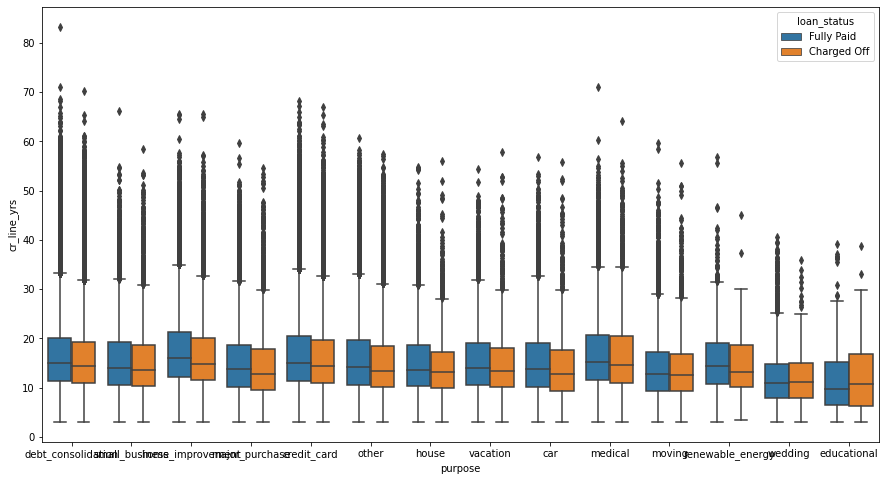

In [23]:
EDA.boxplot(x='purpose', y='cr_line_yrs', hue='loan_status')

Interestingly, all purposes except education have a higher cr_line_yrs value for fully paid loans than charged loans. This is the opposite of what I expected, as I thought younger educatinal loanees may struggle to deal with their debt more. However, this could be due to parents loaning for them or perhaps less privileged students opening credit lines earlier due to a need for working earlier.

Generally though, this variable seems to be less useful and not as indicative of age as hoped.

### Conclusion

We have found strong predictors of default rates in FICO ratings and the number of inquiries, discovered how interest rate reflects risk assessment as well as found a way to extract more information from the variables we have about the economy in general. We also explored less correlated variables and factors. This can all be used for feature engineering for risk calculation or simply understanding what variables one would benefit from adding to the dataset.